In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


In [1]:
! pip install opencv-python matplotlib onnx onnxruntime
#!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

     |████████████████████████████████| 1.0 MB 3.9 MB/s eta 0:00:01
ERROR: tensorboard 2.3.0 has requirement google-auth<2,>=1.6.3, but you'll have google-auth 2.0.2 which is incompatible.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1


In [3]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

mkdir: cannot create directory ‘images’: File exists
--2023-04-17 22:38:44--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg.1’

100%[======================================>] 271,475     --.-K/s   in 0.009s  

2023-04-17 22:38:44 (29.2 MB/s) - ‘images/truck.jpg.1’ saved [271475/271475]

--2023-04-17 22:38:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.160.249.45, 18.160.249.77, 18.160.249.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.160.249.45|:443... connected.
HTTP request sent, await

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [3]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [4]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [5]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)

In [6]:
onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

In [7]:
import warnings

onnx_model_path = "sam_onnx_vit_h.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )   

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [8]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

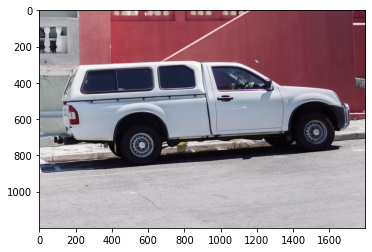

In [9]:
plt.imshow(image)

In [24]:
onnx_model_path

'sam_onnx_vit_h.onnx'

In [10]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [11]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

In [12]:
predictor.set_image(image)

In [13]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [14]:
image_embedding.shape

(1, 256, 64, 64)

In [66]:
input_point = np.array([[500, 375],[700,500]])
input_label = np.array([1,1])

TypeError: Field elements must be 2- or 3-tuples, got '1'

In [67]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
print(onnx_coord.shape)
print(onnx_label.shape)
onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
print(onnx_coord.shape)

(1, 3, 2)
(1, 3)
(1, 3, 2)


In [61]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [62]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [63]:
masks, probs, low_res_logits = ort_session.run(None, ort_inputs)
masks.shape,masks.dtype,probs.shape

((1, 1, 1200, 1800), dtype('float32'), (1, 1))

In [64]:
masks = masks > predictor.model.mask_threshold
masks.shape

(1, 1, 1200, 1800)

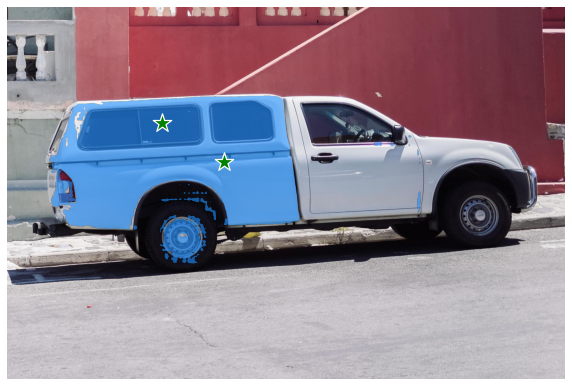

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 